In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import xlwt
import pickle

d:\python\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
mnist = input_data.read_data_sets('MNIST_data',one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
print(mnist.train.images.shape)
print(mnist.train.labels.shape)
print(mnist.test.labels.shape)

(55000, 784)
(55000, 10)
(10000, 10)


In [4]:
def add_layer(inputs,in_size,out_size,n_layer,activation_function=None):
    layer_name='layer%s'%n_layer
    with tf.name_scope(layer_name):
        with tf.name_scope('weights'):
            Weights = tf.Variable(tf.random_normal([in_size,out_size],dtype=tf.float32),name='W')##设权重初始值为随机生成的矩阵
            tf.summary.histogram(layer_name+'/weights',Weights)  ##通过histogram显示
        with tf.name_scope('biases'):   
            biases = tf.Variable(tf.zeros([1,out_size])+0.1,name='b')  ##机器学习中推荐偏置初始值不为0,为什么是一行，n_out列，为啥不是反过来？？？
            tf.summary.histogram(layer_name+'/biases',biases)
            ###回答此问题，可以看看下面的公式
        with tf.name_scope('Wx_plus_b'):
            Wx_plus_b = tf.add(tf.matmul(inputs,Weights),biases)### x*W+B
        if activation_function is None:
            outputs = Wx_plus_b
        else:
            outputs = activation_function(Wx_plus_b)
            tf.summary.histogram(layer_name+'/outputs',outputs)
        return outputs   

def model(X):
    W1 = tf.get_variable('W1',[784,512],initializer=tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable('b1',[512],initializer=tf.zeros_initializer())
    W2 = tf.get_variable('W2',[512,128],initializer=tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable('b2',[128],initializer=tf.zeros_initializer())
    W3 = tf.get_variable('W3',[128,64],initializer=tf.contrib.layers.xavier_initializer())
    b3 = tf.get_variable('b3',[64],initializer=tf.zeros_initializer())
    W4 = tf.get_variable('W4',[64,10],initializer=tf.contrib.layers.xavier_initializer())
    b4 = tf.get_variable('b4',[10],initializer=tf.zeros_initializer())

    # 计算网络中间的logits（就是我们常用的Z）、激活值：全部都是全链接的关系
    A1 = tf.nn.relu(tf.matmul(X,W1)+b1,name='A1')   
    A2 = tf.nn.relu(tf.matmul(A1,W2)+b2,name='A2')
    A3 = tf.nn.relu(tf.matmul(A2,W3)+b3,name='A3')
    Z4 = tf.matmul(A3,W4)+b4   # 输出一定是未激活的函数
    return Z4

def compute_accuracy(v_xs,v_ys):
    global prediction  #将prediction定义为全局变量
    y_pre = sess.run(prediction,feed_dict={x:v_xs})  ##得到1行10列的数据，也就是[1,10]
    correct_prediction = tf.equal(tf.argmax(y_pre,1),tf.argmax(v_ys,1))
    ##取第二维概率最大的（这里索引了最大值的位置），同样标签为最大的值也是我真实的标签值（索引了位置）（我的标签是one_hot类型的）
    ###判断预测和真实标签的index是否一样，一样就代表预测正确，否则就错误
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
    result = sess.run(accuracy,feed_dict={x:v_xs,y:v_ys})
    return result

In [15]:
#3#######################   train

workbook = xlwt.Workbook() 
sheet = workbook.add_sheet("loss") 
###define placeholder for inputs to network
with tf.Graph().as_default():
    x = tf.placeholder(tf.float32,[None,784])  ##28*28，None表示其值大小不定，在这里作为第一个维度值，用以指代batch的大小，意即x的数量不定
    y = tf.placeholder(tf.float32,[None,10])  ##10类输出
    global_steps = tf.Variable(1, trainable=False)

#     prediction = add_layer(x,784,10,n_layer=5,activation_function=tf.nn.softmax)##softmax一般是用来做分类的
    prediction = model(x)
#     cross_entropy = tf.reduce_mean(-tf.reduce_sum(ys*tf.log(prediction),reduction_indices=[1]))##loss
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction,labels=y))
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cost,global_step=global_steps)
    saver = tf.train.Saver()
    costs = []   ##### 一直出现一个问题，这个和上面的损失函数重名了
    
    format_str = "%s    Iteration =  %d   loss = %0.3f"
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for i in range(3000+1):
            batch_x,batch_y = mnist.train.next_batch(batch_size=100)
            loss_val,_ = sess.run([cost,train_step],feed_dict={x:batch_x,y:batch_y})
            costs.append(loss_val)
            sheet.write(i, 0, i)
            loss_new = str(round(loss_val, 3))
            sheet.write(i, 1, loss_new)
            workbook.save('loss_记录.xls')
         
            if i % 50 == 0:
                print('loss_val:',format_str%(datetime.now(), i, loss_val))

            if i % 500 == 0:
                checkpoint = 'saver_classification_练习/' + 'model.ckpt'
                saver.save(sess, checkpoint,global_step=global_steps)
        
            if i % 3000 == 0:
                write_file=open('E:/ivy_machine_learning/program/莫烦学习/teansorflow_learning/classification_loss.pkl','wb')  
                pickle.dump(costs,write_file)  # 将数据存入pickle
                write_file.close() 
        
        ### 训练结束后，看下测试集和训练集上的正确率
        print('test_accuracy:',compute_accuracy(mnist.test.images,mnist.test.labels))
        print('train_accuracy:',compute_accuracy(mnist.train.images,mnist.train.labels))
         

loss_val: 2018-12-05 20:19:13.938990    Iteration =  0   loss = 2.288
loss_val: 2018-12-05 20:19:14.652455    Iteration =  50   loss = 0.463
loss_val: 2018-12-05 20:19:15.217498    Iteration =  100   loss = 0.438
loss_val: 2018-12-05 20:19:15.874197    Iteration =  150   loss = 0.152
loss_val: 2018-12-05 20:19:16.488054    Iteration =  200   loss = 0.179
loss_val: 2018-12-05 20:19:17.167129    Iteration =  250   loss = 0.137
loss_val: 2018-12-05 20:19:17.834328    Iteration =  300   loss = 0.293
loss_val: 2018-12-05 20:19:18.510198    Iteration =  350   loss = 0.118
loss_val: 2018-12-05 20:19:19.217292    Iteration =  400   loss = 0.113
loss_val: 2018-12-05 20:19:20.015576    Iteration =  450   loss = 0.164
loss_val: 2018-12-05 20:19:21.016220    Iteration =  500   loss = 0.351
loss_val: 2018-12-05 20:19:22.153279    Iteration =  550   loss = 0.022
loss_val: 2018-12-05 20:19:22.983110    Iteration =  600   loss = 0.046
loss_val: 2018-12-05 20:19:23.842583    Iteration =  650   loss = 0

INFO:tensorflow:Restoring parameters from saver_classification_练习/model.ckpt-3002
Training set accuracy:  0.99463636
Test set accuracy: 0.9796
true_label VS prediction: 7 7
true_label VS prediction: 2 2
true_label VS prediction: 1 1
true_label VS prediction: 0 0
true_label VS prediction: 0 0
true_label VS prediction: 6 6
true_label VS prediction: 9 9
true_label VS prediction: 0 0
true_label VS prediction: 9 9
true_label VS prediction: 6 6
true_label VS prediction: 6 6
true_label VS prediction: 5 5
true_label VS prediction: 3 3
true_label VS prediction: 1 1
true_label VS prediction: 3 3
true_label VS prediction: 4 4


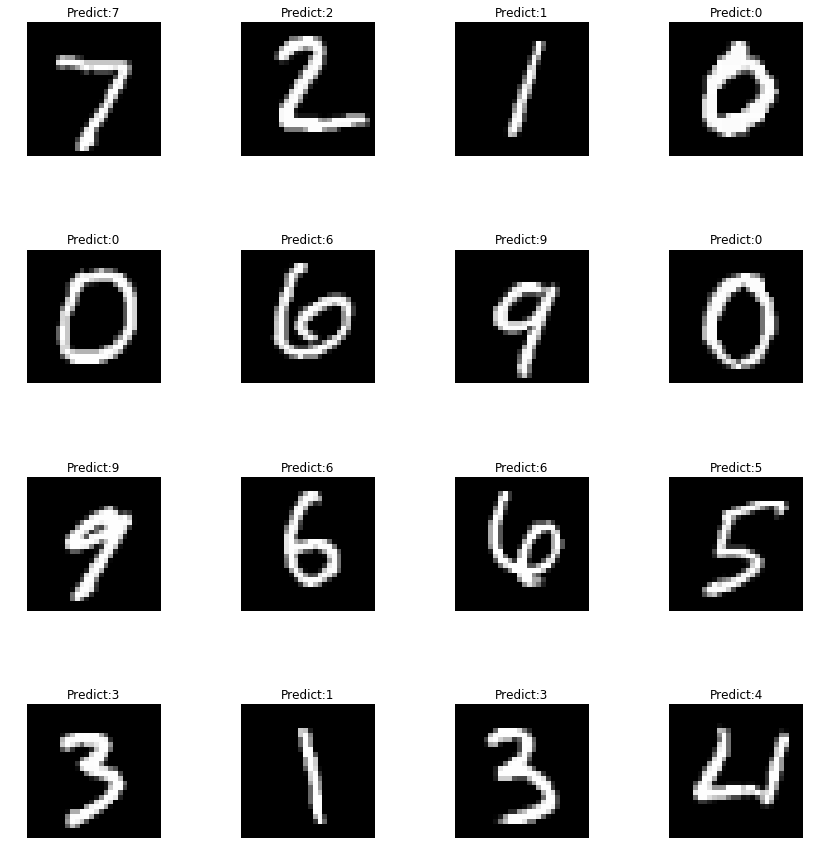

In [5]:
####测试
with tf.Graph().as_default():
    x = tf.placeholder(tf.float32,[None,784])  ##28*28，None表示其值大小不定，在这里作为第一个维度值，用以指代batch的大小，意即x的数量不定
    y = tf.placeholder(tf.float32,[None,10])  ##10类输出f.float32,[None,40],name='Y')  ##40类输出
#     prediction = add_layer(xs,784,10,n_layer=1,activation_function=tf.nn.softmax)##softmax一般是用来做分类的
    prediction = model(x)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, 'saver_classification_练习/model.ckpt-3002')
        pre = sess.run(prediction,feed_dict={x:mnist.test.images})
        print("Training set accuracy: ",compute_accuracy(mnist.train.images,mnist.train.labels))
        print("Test set accuracy:",compute_accuracy(mnist.test.images,mnist.test.labels))
        # 随机从测试集中抽一些图片（比如第i+j张图片），然后取出对应的预测（即z3[i+j]）：
        fig,ax = plt.subplots(4,4,figsize=(15,15))
        fig.subplots_adjust(wspace=0.1, hspace=0.7)
        for i in range(4):
            for j in range(4):
                ax[i,j].imshow(mnist.test.images[10*i+j].reshape(28,28),'gray')
                # 用argmax函数取出z4中最大的数的序号，即为预测结果：
                predicted_num  = np.argmax(pre[10*i+j]) 
                true_label = list(mnist.test.labels[10*i+j]).index(1)
                print("true_label VS prediction:",true_label,predicted_num)
                # 这里不能用tf.argmax，因为所有的tf操作都是在图中，没法直接取出来
                ax[i,j].set_title('Predict:'+str(predicted_num))
                ax[i,j].axis('off')

In [12]:
image = mnist.test.images[3]

In [13]:
image.shape

(784,)

In [14]:
img  = np.reshape(image,[28,28])

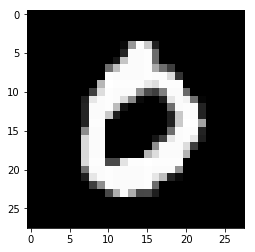

In [16]:
plt.imshow(img,'gray')
plt.show()

## 写数据进入excel

In [9]:
import random
def random_int_list(start, stop, length):
  start, stop = (int(start), int(stop)) if start <= stop else (int(stop), int(start))
  length = int(abs(length)) if length else 0
  random_list = []
  for i in range(length):
    random_list.append(random.randint(start, stop))
  return random_list

In [10]:
a = random_int_list(1,100,30)

In [14]:
import xlwt
import random
workbook = xlwt.Workbook() 
sheet = workbook.add_sheet("data") 
for i in range(30):
    sheet.write(i, 0, i)
    sheet.write(i, 1, a[i])
    workbook.save('Excel_数据2.xls')

## 读pickle的内容，画损失函数-----完成

In [6]:
read_file=open('E:/ivy_machine_learning/program/莫烦学习/teansorflow_learning/手写数字识别/classification_loss.pkl','rb')   
loss = pickle.load(read_file)  # 这时候loss是个list
read_file.close() 

In [10]:
len(loss)

3001

In [19]:
loss_all = np.zeros((3001,2))
for i in range(3001):
    loss_all[i,:]=[i,loss[i]]

In [20]:
loss_all

array([[0.00000000e+00, 2.28844833e+00],
       [1.00000000e+00, 2.13477635e+00],
       [2.00000000e+00, 2.10757685e+00],
       ...,
       [2.99800000e+03, 7.33216777e-02],
       [2.99900000e+03, 3.52574810e-02],
       [3.00000000e+03, 8.14397540e-03]])